In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import data_catalog
import tseries_mod
import esmlab_wrap

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = ['FG_CO2', 'FG_ALT_CO2', 'POC_FLUX_100m']

In [4]:
experiment = 'historical-waccm'
ds_expr = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment)
print(ds_expr)
ds_expr_ann = esmlab_wrap.compute_ann_mean(ds_expr)
# print(ds_expr_ann)

<xarray.Dataset>
Dimensions:        (d2: 2, ensemble: 3, region: 7, time: 1980)
Coordinates:
  * region         (region) object 'Global' 'SouOce' ... 'NH_high_lat'
  * time           (time) object 1850-01-16 13:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: d2, ensemble
Data variables:
    time_bound     (time, d2) object 1850-01-01 02:00:00 ... 2015-01-01 00:00:00
    FG_CO2         (time, region, ensemble) float32 -0.29951245 ... 0.3507981
    FG_ALT_CO2     (time, region, ensemble) float32 -0.44810727 ... 0.2114369
    POC_FLUX_100m  (time, region, ensemble) float32 6.9623103 ... 0.020012485
Attributes:
    title:             b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001
    history:           created by /glade/work/klindsay/analysis/CESM2_coup_ca...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Va

In [5]:
# load Dataset for corresponding experiment_ctrl
experiment_ctrl = data_catalog.find_in_index(experiment=experiment).ctrl_experiment.unique()[0]
print(experiment_ctrl)
ds_ctrl = tseries_mod.tseries_get_vars(varnames, 'ocn', experiment_ctrl)
print(ds_ctrl)
ds_ctrl_ann = esmlab_wrap.compute_ann_mean(ds_ctrl)
# print(ds_ctrl_ann)

piControl-waccm
<xarray.Dataset>
Dimensions:        (d2: 2, region: 7, time: 5988)
Coordinates:
  * time           (time) object 0001-01-16 12:59:59 ... 0499-12-16 12:00:00
  * region         (region) object 'Global' 'SouOce' ... 'NH_high_lat'
Dimensions without coordinates: d2
Data variables:
    FG_CO2         (time, region) float32 -0.3390921 -0.09639507 ... 0.14755027
    time_bound     (time, d2) object 0001-01-01 01:59:59 ... 0500-01-01 00:00:00
    FG_ALT_CO2     (time, region) float32 -0.39043343 -0.11501262 ... 0.13940874
    POC_FLUX_100m  (time, region) float32 7.205978 3.2021403 ... 0.020083433
Attributes:
    title:             b.e21.BW1850.f09_g17.CMIP6-piControl.001
    history:           created by /glade/work/klindsay/analysis/CESM2_coup_ca...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
  

In [6]:
# add FG_ANTH_CO2 to datasets
for ds in [ds_expr_ann, ds_ctrl_ann]:
    ds['FG_ANTH_CO2'] = ds['FG_CO2'] - ds['FG_ALT_CO2']
# print(ds_expr_ann)
# print(ds_ctrl_ann)
varnames.append('FG_ANTH_CO2')

In [7]:
# construct year range of experiment_ctrl to use for detrending
branch_years = data_catalog.find_in_index(experiment=experiment).ctrl_branch_year.unique()
yr_lo = branch_years.min() - 50
yyyymmdd_lo = str(int(yr_lo)).zfill(4)+'-01-01'
yr_hi = branch_years.max() + 50 + len(ds_expr_ann.time)
yyyymmdd_hi = str(int(yr_hi)).zfill(4)+'-01-01'
print((yyyymmdd_lo, yyyymmdd_hi))

('0006-01-01', '0285-01-01')


In [8]:
# compute experiment_ctrl mean, for detrending
ds_ctrl_ann_slice_mean = ds_ctrl_ann.sel(time=slice(yyyymmdd_lo, yyyymmdd_hi)).mean(dim='time')
print(ds_ctrl_ann_slice_mean.FG_CO2)
print(ds_ctrl_ann_slice_mean.FG_ALT_CO2)
print(ds_ctrl_ann_slice_mean.FG_ANTH_CO2)
print(ds_ctrl_ann_slice_mean.POC_FLUX_100m)

<xarray.DataArray 'FG_CO2' (region: 7)>
array([-0.06194964,  0.21353362, -0.18290155,  0.51232029, -1.0263827 ,
        0.36979105,  0.26522326])
Coordinates:
  * region   (region) object 'Global' 'SouOce' ... 'NH_mid_lat' 'NH_high_lat'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ALT_CO2' (region: 7)>
array([-0.05766982,  0.21660642, -0.18241901,  0.51436837, -1.02491445,
        0.36949148,  0.26580379])
Coordinates:
  * region   (region) object 'Global' 'SouOce' ... 'NH_mid_lat' 'NH_high_lat'
Attributes:
    long_name:     Integrated DIC Surface Gas Flux, Alternative CO2
    units:         Pg yr-1
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'FG_ANTH_CO2' (region: 7)>
array([-0.00427982, -0.0030728 , -0.00048254, -0.00204808, -0.00146825,
        0.00029957, -0.00058053])
Coordinates:
  * region   (region) object 'Global' 'SouOce' ... 'N

In [9]:
ds_expr_ann_detrended = ds_expr_ann - ds_ctrl_ann_slice_mean

In [10]:
# add cummulate flux vars to datasets
for ds in [ds_expr_ann, ds_expr_ann_detrended]:
    for varname in varnames:
        da = ds[varname].cumsum(dim='time', keep_attrs=True)
        da.name = varname+'_CUM'
        da.attrs['units'] = 'Pg'
        ds[da.name] = da

# print(ds_expr_ann)
# print(ds_expr_ann_detrended)

array([126.95191318, 128.13189852, 130.11603944])

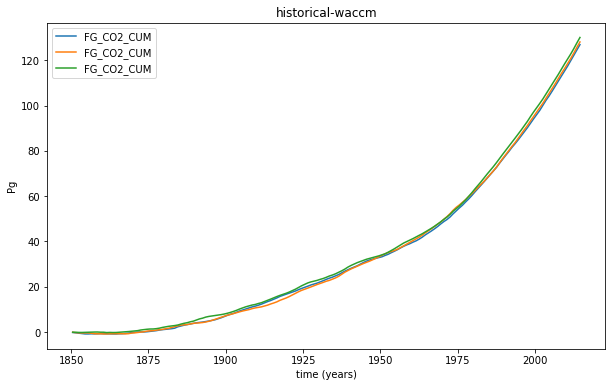

In [11]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([132.56500761, 132.55610931, 132.80556254])

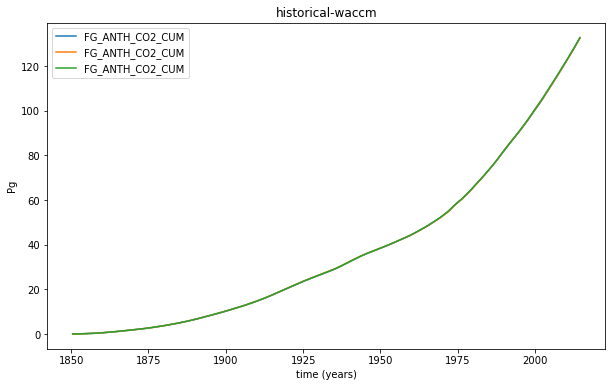

In [12]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([137.17360446, 138.35358979, 140.33773071])

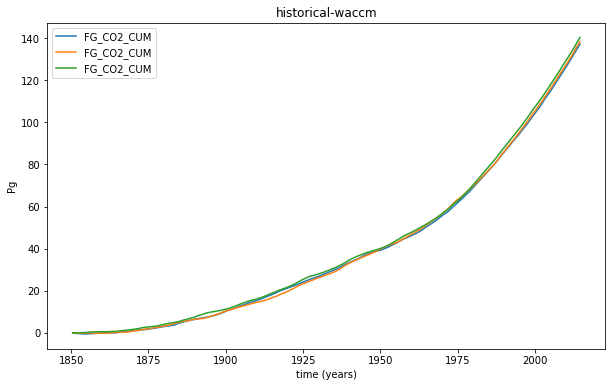

In [13]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([133.27117809, 133.26227979, 133.51173302])

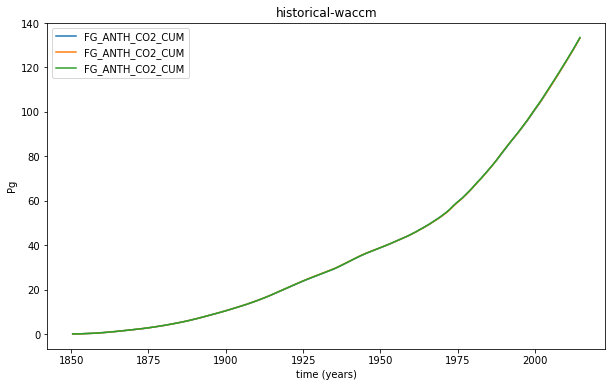

In [14]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ANTH_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ANTH_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([3.90242637, 5.09131   , 6.82599769])

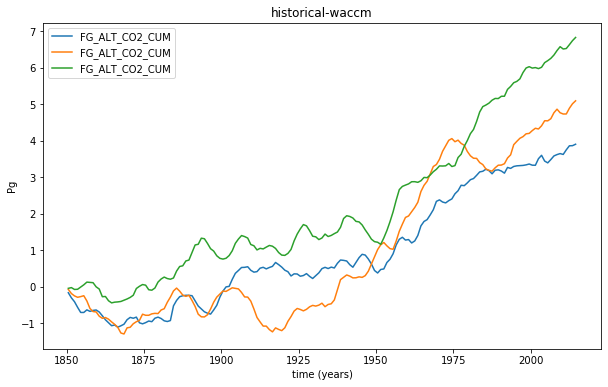

In [15]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

array([-5.61309442, -4.42421079, -2.6895231 ])

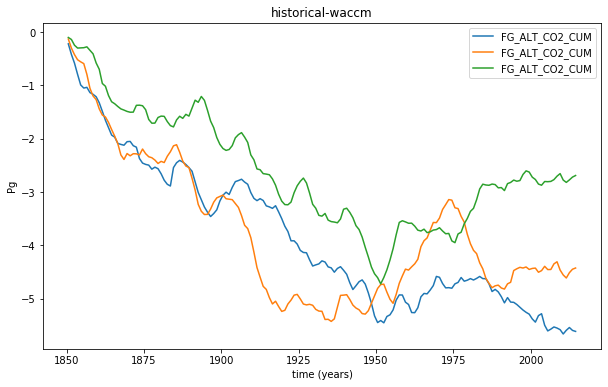

In [16]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['FG_ALT_CO2_CUM'], title=experiment, region_val='Global')
ds_expr_ann['FG_ALT_CO2_CUM'].sel(region='Global').isel(time=-1).values

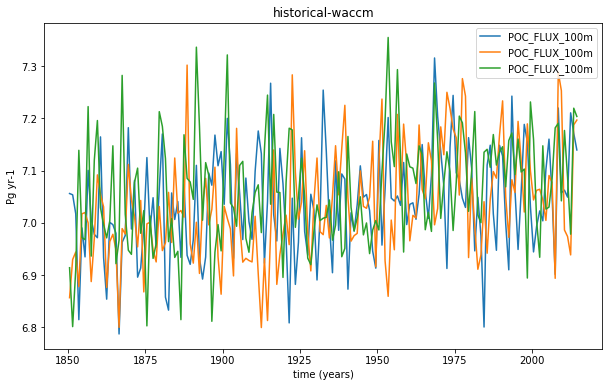

In [17]:
tseries_mod.tseries_plot_1ds(ds_expr_ann, ['POC_FLUX_100m'], title=experiment, region_val='Global')

array([ 6.53438279,  5.51645549, 10.62933178])

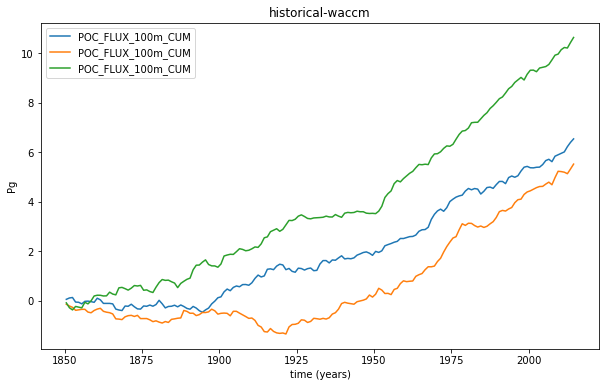

In [18]:
tseries_mod.tseries_plot_1ds(ds_expr_ann_detrended, ['POC_FLUX_100m_CUM'], title=experiment, region_val='Global')
ds_expr_ann_detrended['POC_FLUX_100m_CUM'].sel(region='Global').isel(time=-1).values